<br><br><br><br><br><br>

### 3층 신경망


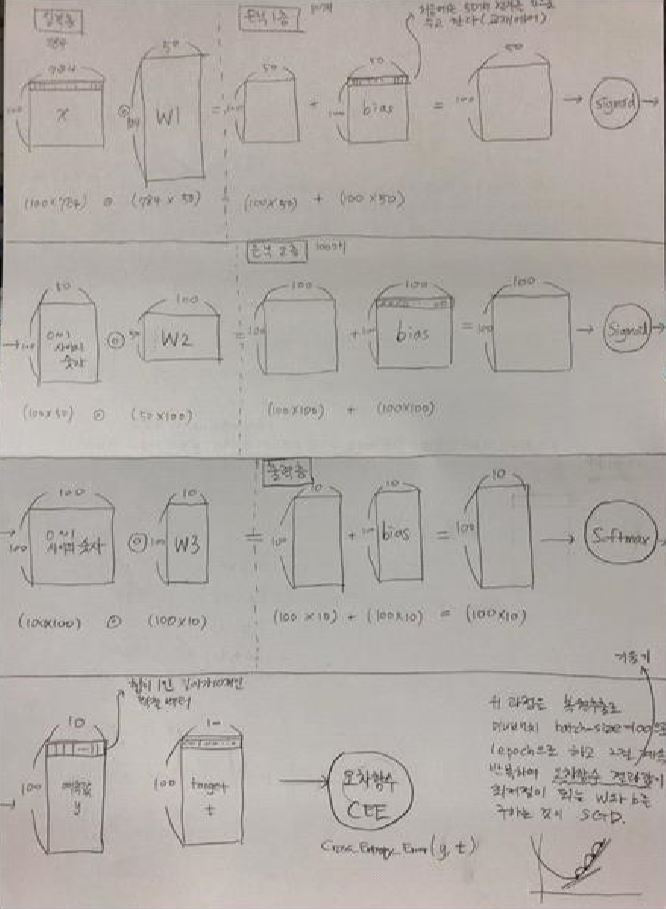

<br><br><br>

#### 수치미분을 이용한 2층 신경망 코드

In [2]:
# coding: utf-8 

import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정 

import numpy as np 
import matplotlib.pyplot as plt 
from dataset.mnist import load_mnist #from prac.common.functions import * #from prac.common.gradient import numerical_gradient


def sigmoid(x):  
    
    return 1 / (1 + np.exp(-x))


def softmax(a):   
    
    c = np.max(a)    
    exp_a = np.exp(a)    
    sum_exp_a = np.sum(exp_a)    
    y = exp_a / sum_exp_a    
    
    return y

def crossEntropyError(y, t):    
    
    delta = 1e-7 #아주 작은 값 (y가 0인 경우 -inf 값을 예방)   
    
    return -np.sum(t*np.log(y+delta)) / y.shape[0]

# def numerical_gradient(f,x): 
#     h = 1e-4 
#     grad = np.zeros_like(x) 
# 
#     for idx in range(x.size): 
#         tmp_val = x[idx] 
#         x[idx] = tmp_val + h 
#         fxh1 = f(x) # f(x+h) 를 계산 
# 
#         x[idx] = tmp_val - h 
#         fxh2 = f(x) # f(x-h) 를 계산 
# 
#         grad[idx] = (fxh1 - fxh2) / (2*h) 
#         x[idx]= tmp_val 
# 값 복원 
#
#     return grad

def numerical_gradient(f, x):    
    
    h = 1e-4  # 0.0001    
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])    
    
    while not it.finished:
        
        idx = it.multi_index        
        tmp_val = x[idx]        
        x[idx] = float(tmp_val) + h        
        fxh1 = f(x)  # f(x+h)
        x[idx] = tmp_val - h        
        fxh2 = f(x)  
        
        # f(x-h)        
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val  # 媛?蹂듭썝        
        it.iternext()
        
    return grad

class TwoLayerNet:    
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):        
        self.params = {}        
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)       
        self.params['b1'] = np.zeros(hidden_size)        
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)        
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):        
        W1, W2 = self.params['W1'], self.params['W2']        
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1        
        z1 = sigmoid(a1)        
        a2 = np.dot(z1, W2) + b2        
        y = softmax(a2)
        
        return y
    
    
    def loss(self, x,t): 
        
        y = self.predict(x)
        
        return crossEntropyError(y, t)
    
    
    def accuracy(self, x, t):
        
        y = self.predict(x)        
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])        
        
        return accuracy
    
    
    def numerical_gradient(self,x,t):        
        loss_W = lambda W: self.loss(x,t)
        
        grads = {}        
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])        
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])        
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])        
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
# 데이터 읽기 

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터 
iters_num = 10000  

# 반복 횟수를 적절히 설정한다. 
train_size = x_train.shape[0] 
batch_size = 100  

# 미니배치 크기 
learning_rate = 0.1
train_loss_list = [] 
train_acc_list = [] 
test_acc_list = []

# 1에폭당 반복 수 
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):    # 미니배치 획득    
    batch_mask = np.random.choice(train_size, batch_size)    
    x_batch = x_train[batch_mask]    
    t_batch = t_train[batch_mask]
    
    # 기울기 계산    
    grad = network.numerical_gradient(x_batch, t_batch)    
    #grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신    
    for key in ('W1', 'b1', 'W2', 'b2'):        
        network.params[key] -= learning_rate * grad[key]
        
    # 학습 경과 기록    
    loss = network.loss(x_batch, t_batch)    
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산    
    if i % iter_per_epoch == 0:        
        train_acc = network.accuracy(x_train, t_train)        
        test_acc = network.accuracy(x_test, t_test)        
        train_acc_list.append(train_acc)        
        test_acc_list.append(test_acc)        
        
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
    
    
# # 그래프 그리기 
# markers = {'train': 'o', 'test': 's'} 
# x = np.arange(len(train_acc_list)) 
# plt.plot(x, train_acc_list, label='train acc') 
# plt.plot(x, test_acc_list, label='test acc', linestyle='--') 
# plt.xlabel("epochs") 
# plt.ylabel("accuracy") 
# plt.ylim(0, 1.0) 
# plt.legend(loc='lower right') 
# plt.show()


<br><br><br><br><br>

#### 위의 코드 분해해서 이해

<br><br><br><br>

##### 문제 56)  TwoLayerNet 클래스로 객체를 생성하고 W1, W2, b1, b2 의 행렬의 모양을 확인하시오


In [3]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10) 

print('w1',network.params.get('W1').shape) 
print('w2',network.params.get('W2').shape) 
print('b1',network.params.get('b1').shape)
print('b1',network.params.get('b1').shape) 
print('b2',network.params.get('b2').shape)


w1 (784, 50)
w2 (50, 10)
b1 (50,)
b1 (50,)
b2 (10,)


<br><br><br><br><br>

###### 문제 57)  TwoLayerNet 클래스의 객체를 생성하고 predict 메소드를 실행하여 나온 결과의 행렬의 shape를 출력하시오 


In [4]:
# 데이터 읽기 
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True) 
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10) 
network.predict(x_train)[:100].shape

(100, 10)

<br><br><br><br><br>

###### 문제 58)  TwoLayerNet 클래스의 객체를 생성하고 crossEntropyError(y, t) 메소드를 실행해서 나온 출력결과인 오차를 출력하시오.

In [5]:
# 데이터 읽기 

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True) 
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10) 
y = network.predict(x_train)[:100] 
t = t_train[:100] 

print('오차:', crossEntropyError(y, t))

오차: 13.252206872733241


<br><br><br><br><br><br>

#### accuracy 함수의 이해

예상한 숫자와 실제 숫자를 비교해서 정확도를 출력하는 함수
 

<br><br><br>

##### 문제 59)  TwoLayerNet 클래스로 객체를 생성하고 accuracy(x, t) 메소드를 실행해서 100장 훈련데이터와 100장의 target 데이터를 입력했을 때의 정확도를 출력하시오
 

In [7]:
# 데이터 읽기 
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True) 
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10) 
y = x_train[:100] 
t = t_train[:100] 
print('오차:', network.loss(y, t))

# 정확도
print('정확도:', network.accuracy(y, t))


오차: 6.909693290484333
정확도: 0.08


<br><br><br><br><br>

#### numerical_gradient 함수 

비용함수와 가중치 또는 Bias를 입력받아 기울기를 출력하는 함수

비용함수 생성 방법

In [8]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10) 

def f(W):    
    return network.loss(x, t)

설명) <br>여기서 정의한 f(W) 함수의 W는 더미로 만든 것입니다.<br> numerical_gradien(f, x) 내부에서 f(x)를 실행하는데 그와의 일관성을 위해서 f(W)를 정의한 것


In [ ]:
# coding: utf-8 
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정 
import numpy as np 
import matplotlib.pyplot as plt 
from dataset.mnist import load_mnist 
#from common.functions import * 

#from common.gradient import numerical_gradient
def sigmoid(x):    
    return 1 / (1 + np.exp(-x))

def softmax(a):   
    c = np.max(a)    
    exp_a = np.exp(a)    
    sum_exp_a = np.sum(exp_a)    
    y = exp_a / sum_exp_a    
    return y

def crossEntropyError(y, t):    
    delta = 1e-7 #아주 작은 값 (y가 0인 경우 -inf 값을 예방)    
    return -np.sum(t*np.log(y+delta)) / y.shape[0]

# def numerical_gradient(f,x): 
#     h = 1e-4 
#     grad = np.zeros_like(x) 
# 
#     for idx in range(x.size): 
#         tmp_val = x[idx] 
#         x[idx] = tmp_val + h 
#         fxh1 = f(x) # f(x+h) 를 계산 
#
#         x[idx] = tmp_val - h 
#         fxh2 = f(x) # f(x-h) 를 계산 
# 
#         grad[idx] = (fxh1 - fxh2) / (2*h) 
#         x[idx]= tmp_val # 값 복원 
# 
#     return grad

def numerical_gradient(f, x):    
    h = 1e-4  # 0.0001    
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])    
    
    while not it.finished:        
        idx = it.multi_index 
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h        
        fxh1 = f(x)  
        
        # f(x+h)
        x[idx] = tmp_val - h        
        fxh2 = f(x) 
        
        # f(x-h)        
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val  # 媛?蹂듭썝        
        it.iternext()
        
    return grad

class TwoLayerNet:    
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):        
        self.params = {}        
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)       
        self.params['b1'] = np.zeros(hidden_size)        
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)        
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):        
        W1, W2 = self.params['W1'], self.params['W2']        
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1        
        z1 = sigmoid(a1)        
        a2 = np.dot(z1, W2) + b2        
        y = softmax(a2)
        
        return y
    
    
    def loss(self, x,t): 
        
        y = self.predict(x)
        
        return crossEntropyError(y, t)
    
    
    def accuracy(self, x, t):
        
        y = self.predict(x)        
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])        
        
        return accuracy
    
    
    def numerical_gradient(self,x,t):        
        loss_W = lambda W: self.loss(x,t)
        
        grads = {}        
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])        
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])        
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])        
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    
# 데이터 읽기 

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

print(network.loss(x_train[:100], t_train[:100]))


# 하이퍼파라미터 

iters_num = 10000  

# 반복 횟수를 적절히 설정한다. 

train_size = x_train.shape[0] 
batch_size = 100  

# 미니배치 크기 

learning_rate = 0.1
train_loss_list = [] 
train_acc_list = [] 
test_acc_list = []

# 1에폭당 반복 수 

iter_per_epoch = max(train_size / batch_size, 1)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
(x_train, t_train) , (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
x = x_train[:100] 
t = t_train[:100]


def f(W):    
    return  network.loss(x,t)

W1_grad = numerical_gradient( f, network.params.get('W1') )

print (W1_grad)


<br><br><br><br><br>

#### lambda 표현식 이란?


In [ ]:
# coding: utf-8 
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정 
import numpy as np 
import matplotlib.pyplot as plt 
from dataset.mnist import load_mnist 
#from common.functions import * 

#from common.gradient import numerical_gradient
def sigmoid(x):    
    return 1 / (1 + np.exp(-x))

def softmax(a):   
    c = np.max(a)    
    exp_a = np.exp(a)    
    sum_exp_a = np.sum(exp_a)    
    y = exp_a / sum_exp_a    
    return y

def crossEntropyError(y, t):    
    delta = 1e-7 #아주 작은 값 (y가 0인 경우 -inf 값을 예방)    
    return -np.sum(t*np.log(y+delta)) / y.shape[0]

# def numerical_gradient(f,x): 
#     h = 1e-4 
#     grad = np.zeros_like(x) 
# 
#     for idx in range(x.size): 
#         tmp_val = x[idx] 
#         x[idx] = tmp_val + h 
#         fxh1 = f(x) # f(x+h) 를 계산 
#
#         x[idx] = tmp_val - h 
#         fxh2 = f(x) # f(x-h) 를 계산 
# 
#         grad[idx] = (fxh1 - fxh2) / (2*h) 
#         x[idx]= tmp_val # 값 복원 
# 
#     return grad

def numerical_gradient(f, x):    
    h = 1e-4  # 0.0001    
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])    
    
    while not it.finished:        
        idx = it.multi_index 
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h        
        fxh1 = f(x)  
        
        # f(x+h)
        x[idx] = tmp_val - h        
        fxh2 = f(x) 
        
        # f(x-h)        
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val  # 媛?蹂듭썝        
        it.iternext()
        
    return grad

class TwoLayerNet:    
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):        
        self.params = {}        
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)       
        self.params['b1'] = np.zeros(hidden_size)        
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)        
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):        
        W1, W2 = self.params['W1'], self.params['W2']        
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1        
        z1 = sigmoid(a1)        
        a2 = np.dot(z1, W2) + b2        
        y = softmax(a2)
        
        return y
    
    
    def loss(self, x,t): 
        
        y = self.predict(x)
        
        return crossEntropyError(y, t)
    
    
    def accuracy(self, x, t):
        
        y = self.predict(x)        
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])        
        
        return accuracy
    
    
    def numerical_gradient(self,x,t):        
        loss_W = lambda W: self.loss(x,t)
        
        grads = {}        
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])        
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])        
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])        
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    
# 데이터 읽기 

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

print(network.loss(x_train[:100], t_train[:100]))


# 하이퍼파라미터 

iters_num = 10000  # 반복 횟수를 적절히 설정한다. 

train_size = x_train.shape[0] 
batch_size = 100  #미니배치 크기 

learning_rate = 0.1

train_loss_list = [] 
train_acc_list = [] 
test_acc_list = []

# 1에폭당 반복 수 

iter_per_epoch = max(train_size / batch_size, 1)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

(x_train, t_train) , (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

x = x_train[:100] 
t = t_train[:100]


def f(W):    
    return  network.loss(x,t)

W1_grad = numerical_gradient( f, network.params.get('W1') )

print (W1_grad)


<br><br><br><br><br>

##### 문제 60) 아래의 비용함수를 lambda 표현식으로 한줄로 변경해서 출력하시오


보기) <br>def f(W):   <br>
　　return  network.loss(x,t)


In [14]:
f = lambda W: network.loss(x,t)

<br><br><br><br><br>

##### 문제 61)  TwoLayerNet 클래스를 가지고 학습 시키는 코드를 완성시키시오


In [ ]:
# 데이터 읽기 

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)



# 하이퍼파라미터 

iters_num = 10000  # 반복 횟수를 적절히 설정한다. 

train_size = x_train.shape[0]   # x_train : (60000, 784) 
batch_size = 100  #미니배치 크기 

learning_rate = 0.1

#그래프 그릴떄 필요한 데이터를 담을 리스트 변수 3개를 선언
train_loss_list = []  # 훈련데이터의 손실 
train_acc_list = []  # 훈련데이터의 정확도 
test_acc_list = []    # 테스트 데이터의 정확도

# 1에폭당 반복 수 

iter_per_epoch = max(train_size / batch_size, 1)
# 60000 / 100 = 600 => max(600, 1) = 600


for i in range(iters_num):    
    # 미니배치 획득  # 랜덤으로 100개 씩 뽑는 작업을 10000번 수행    
    batch_mask = np.random.choice(train_size, batch_size)    
    # 0 ~ 60000 의 숫자 중에 100개를 랜덤으로 생성    
    x_batch = x_train[batch_mask]    
    t_batch = t_train[batch_mask]
    
    # 기울기 계산    
    grad = network.numerical_gradient(x_batch, t_batch)    
    #grad = network.gradient(x_batch, t_batch)      
    # 오차역전파를 이용한 기울기 구하는 함수 (빠름, 나중에 배울 예정)
    
    # 매개변수 갱신    
    for key in ('W1', 'b1', 'W2', 'b2'):        
        network.params[key] -= learning_rate * grad[key]
        
    # 학습 경과 기록   # 손실(비용)이 점점 줄어드는 것을 보기 위해    
    loss = network.loss(x_batch, t_batch)    
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산    
    if i % iter_per_epoch == 0:   # 600/600, 1200/600, 1800/600 ...       
        train_acc = network.accuracy(x_train, t_train)        
        test_acc = network.accuracy(x_test, t_test)       
        train_acc_list.append(train_acc)        
        test_acc_list.append(test_acc)        
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


<br><br><br><br><br>

##### 문제 62)   수치미분이 아닌 오차 역전파를 이용한 신경망 학습으로 2층 신경망 코드를 구현하시오


train acc, test acc | 0.09138333333333333, 0.0909
train acc, test acc | 0.9048666666666667, 0.907
train acc, test acc | 0.9229333333333334, 0.9249
train acc, test acc | 0.9336166666666667, 0.9334
train acc, test acc | 0.9435833333333333, 0.9427
train acc, test acc | 0.9499, 0.9477
train acc, test acc | 0.9554333333333334, 0.9523
train acc, test acc | 0.9609, 0.9589
train acc, test acc | 0.9637, 0.962
train acc, test acc | 0.9676833333333333, 0.9647
train acc, test acc | 0.9702333333333333, 0.9675
train acc, test acc | 0.9719833333333333, 0.9693
train acc, test acc | 0.97315, 0.9681
train acc, test acc | 0.9744833333333334, 0.968
train acc, test acc | 0.9771166666666666, 0.9705
train acc, test acc | 0.9768833333333333, 0.9697
train acc, test acc | 0.97855, 0.9712


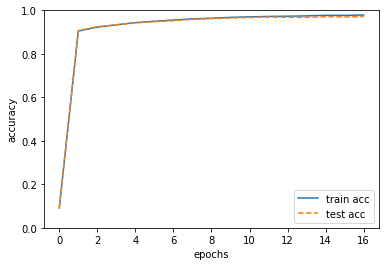

In [5]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: 
            t = np.argmax(t, axis=1)
            accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            # 결과 저장
            grads = {}
            grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
            grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grads
    
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000 # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100 # 미니배치 크기
learning_rate = 0.1
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)
for i in range(iters_num): # 10000
    # 미니배치 획득 # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 기울기 계산
    # grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) # cost 가 점점 줄어드는것을 보려고
    
    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크
    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.
        
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개 16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc) # 10000/600 개 16개 # 정확도가 점점 올라감
        
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()